## Теоретическая часть


1. Ответьте на вопросы:  
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?  
Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы  

### Ответ ###
*Отличие коллаборативной фильтрации от гибридных рекомендательных систем, заключается в следующем, коллаборативная фильтрация этот один из методов используемых для построения рекомендательных систем, основанный на предпочтениях похожих пользователей, а гибридная рекомендательная система явлеяется системой и может в себя включать разные методы, в том числе и метод коллаборативной фильтрации.*




2.  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

### Ответ ###
Коллеги из hh.ru используют в своей рек.системе журналы действий пользователей, возрастающее усложение и расчетные статистические признаки их система гораздо сложнее чем рассматривали на семинаре, но на мой взгляд подход у нас с ними общие. 
При выводе в продакшен, результат может прийти не сразу, системе придется потратить время на обучение, а коллегам на доработку журналов действий пользователей, всё сразу нельзя учесть.

3. На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
2) Что используют в качестве признаков?  
3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  

### Ответ ###
1 и 2. датасеты MovieLens 10M (relevance,rating,timestamp,title,genres) и CrossValidated ( questions,  answers)<br>
3. LSI-LR, LSI-UP,MF.  MF - матричная модель факторизации пользователь*элемент с функцией сигмоида. LSI-LR основанная на контенте матричная модель с линейной регресией. LSI-UP - гибридная модель базирующаяся на профилях пользователей с сингулярным разложением матрицы

## Практическая часть


### 1. Модуль SRC

На вебинаре было рассказано про модуль src. Он приложен в материалах. Скачайте его, изучите структуру, импортируйте функции

In [1]:
import numpy as np 
import pandas as pd

from src.metrics import precision_at_k, recall_at_k
from src.recommenders import MainRecommender
from src.utils import prefilter_items

import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix, coo_matrix  
import lightfm.evaluation
import seaborn as sns

import lightfm

### 2. Работа с признаками

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

In [2]:
data = pd.read_csv('../rec_data/transaction_data.csv')
item_features = pd.read_csv('../rec_data/product.csv')
user_features = pd.read_csv('../rec_data/hh_demographic.csv')

In [49]:
data.empty,item_features.empty,user_features.empty

(False, False, False)

In [3]:
data.head(3)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [7]:
data.describe().style.set_precision(0)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
count,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732,2595732
mean,1272,34026199139,389,2891435,100,3,3143,-1,1562,56,-0,-0
std,726,4711649038,190,3837404,1153,4,8937,1,400,27,0,0
min,1,26984851472,1,25671,0,0,1,-180,0,1,-56,-8
25%,656,30408046256,229,917459,1,1,330,-1,1308,33,0,0
50%,1272,32760806548,390,1028816,1,2,372,-0,1613,56,0,0
75%,1913,40126853628,553,1133018,1,3,422,0,1843,80,0,0
max,2500,42305362535,711,18316298,89638,840,34280,4,2359,102,0,0


In [74]:
data['household_key'].unique().size

2500

In [25]:
#кривые скидки
data[(data['RETAIL_DISC'] < -99)|(data['RETAIL_DISC'] > 0)]

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
752808,801,30822926936,256,12810391,7,1.057500e+02,329,-1.299800e+02,1347,37,0.0,0.0
968972,1306,31624096856,310,990941,0,1.000000e-02,340,1.000000e-02,2253,45,0.0,0.0
1001608,1306,31735306143,318,7409789,0,0.000000e+00,381,2.220446e-16,1232,46,0.0,0.0
1023085,1321,31803641901,323,1051069,0,0.000000e+00,364,5.551115e-17,1931,47,0.0,0.0
1023086,1321,31803641901,323,1055863,0,0.000000e+00,364,5.551115e-17,1931,47,0.0,0.0
1067337,37,31944616637,334,8090539,0,0.000000e+00,381,2.220446e-16,1434,48,0.0,0.0
1143255,2241,32173242560,353,995242,0,0.000000e+00,296,2.220446e-16,2325,51,0.0,0.0
1210504,923,32446036423,369,1047226,0,0.000000e+00,410,1.110223e-16,1541,53,0.0,0.0
1215551,1535,32478752229,370,999270,1,7.980000e+00,360,3.990000e+00,1852,54,0.0,0.0
1216489,2491,32478901200,370,13945244,0,4.440892e-16,389,1.110223e-16,1315,54,0.0,0.0


In [5]:
item_features.head(3)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [32]:
item_features.shape

(92353, 7)

In [28]:
item_features['DEPARTMENT'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [54]:
item_features['BRAND'].unique()

array(['National', 'Private'], dtype=object)

In [46]:
item_features['COMMODITY_DESC'].unique()
item_features.query('COMMODITY_DESC == "NO COMMODITY DESCRIPTION"')['MANUFACTURER'].agg(['nunique','count','size','unique'])

nunique                                                  302
count                                                    490
size                                                     490
unique     [2, 2241, 952, 5176, 673, 5098, 382, 1543, 68,...
Name: MANUFACTURER, dtype: object

In [55]:
user_features.head(3)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [75]:
user_features['household_key'].unique().size

801

In [72]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_DESC             801 non-null    object
 1   MARITAL_STATUS_CODE  801 non-null    object
 2   INCOME_DESC          801 non-null    object
 3   HOMEOWNER_DESC       801 non-null    object
 4   HH_COMP_DESC         801 non-null    object
 5   HOUSEHOLD_SIZE_DESC  801 non-null    object
 6   KID_CATEGORY_DESC    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [59]:
user_features['MARITAL_STATUS_CODE'].unique(),user_features['INCOME_DESC'].unique(),user_features['AGE_DESC'].unique()

(array(['A', 'U', 'B'], dtype=object),
 array(['35-49K', '50-74K', '25-34K', '75-99K', 'Under 15K', '100-124K',
        '15-24K', '125-149K', '150-174K', '250K+', '175-199K', '200-249K'],
       dtype=object),
 array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object))

In [64]:
user_features['HH_COMP_DESC'].unique(),user_features['HOMEOWNER_DESC'].unique()

(array(['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown',
        'Single Male', '1 Adult Kids'], dtype=object),
 array(['Homeowner', 'Unknown', 'Renter', 'Probable Renter',
        'Probable Owner'], dtype=object))

In [70]:
user_features[(user_features['HH_COMP_DESC'] == 'Unknown')].size

584

**Краткое резюме по данным**

Данные из трех файлов можно связать по ключевым полям household_key, PRODUCT_ID.<br><br>
В data есть ошибочные данные, например для скидок. время покупки TRANS_TIME в data заданы как 4х значное число, можно преобразовать.<br><br>
В даных по товарам, например можно использовать и преобразовать DEPARTMENT и BRAND<br><br>
В пользовательских признаках все признаки можно трансформировать или использовать как доп признаки.

In [80]:

#переименовываем заголовки столбцов, для удобства работы, все строчные
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]
data.columns = [col.lower() for col in data.columns]

# переименовываем заголовки для user и item
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)
data.rename(columns={'household_key': 'user_id'}, inplace=True)
data.rename(columns={'product_id': 'item_id'}, inplace=True)


 (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары)

In [191]:
test = data.copy()

In [192]:
test = test.merge(item_features, on='item_id', how='left')

In [193]:
test = test.merge(user_features, on='user_id', how='left')

In [202]:
data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2595727,1598,42305362535,711,92130,1,0.99,3228,0.00,1520,102,0.0,0.0
2595728,1598,42305362535,711,114102,1,8.89,3228,0.00,1520,102,0.0,0.0
2595729,1598,42305362535,711,133449,1,6.99,3228,0.00,1520,102,0.0,0.0
2595730,1598,42305362535,711,6923644,1,4.50,3228,-0.49,1520,102,0.0,0.0


In [195]:
list_income = ('Under 15K',  '15-24K',  '25-34K', '35-49K', '50-74K', '75-99K',  '100-124K','125-149K', '150-174K','175-199K', '200-249K', '250K+')

In [196]:
i = 1
for ind in list_income:
    test.loc[(test['income_desc']==ind), 'income_indx'] = i
    i+=1;
test['income_indx']=test['income_indx'].fillna(0)

In [219]:
list_dept = list(item_features['department'].unique())

In [266]:
len(list_dept)

44

In [221]:
i = 1
for ind in list_dept:
    test.loc[(test['department']==ind), 'dept_indx'] = i
    i+=1;
test['dept_indx']=test['dept_indx'].fillna(0)

### пользователи с большим достатком предпочитают товары следующих категорий: ###

array([[<AxesSubplot:title={'center':'dept_indx'}>]], dtype=object)

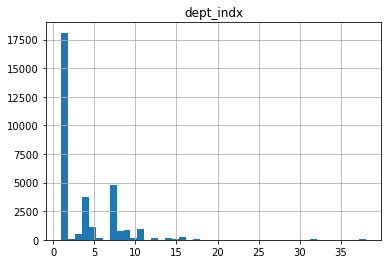

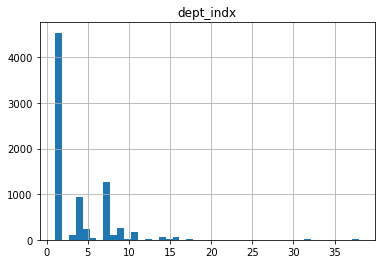

In [472]:
test[test.income_desc == '250K+'].hist('dept_indx',bins=len(list_dept))
test[test.income_desc == '200-249K'].hist('dept_indx',bins=len(list_dept))

In [287]:
test['weekday'] = test['day'] % 7 + 1

### товары такой-то категории болле часто покупаются в следующие дни недели

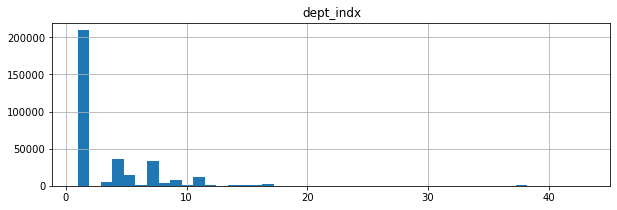

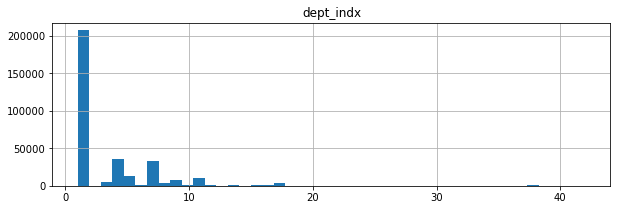

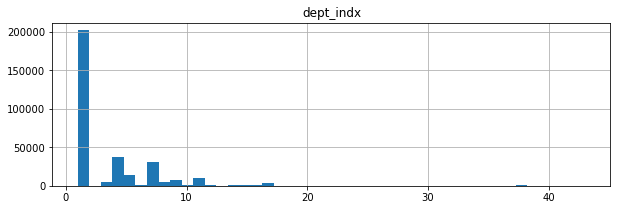

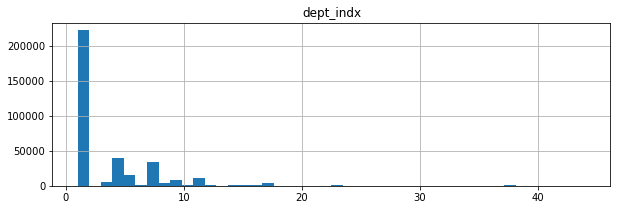

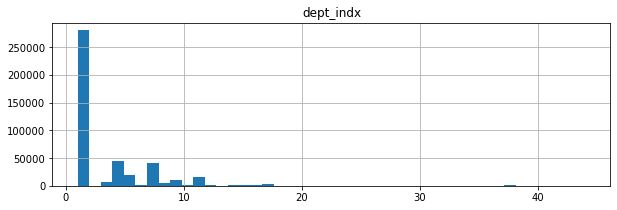

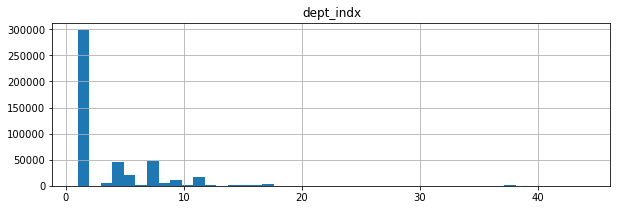

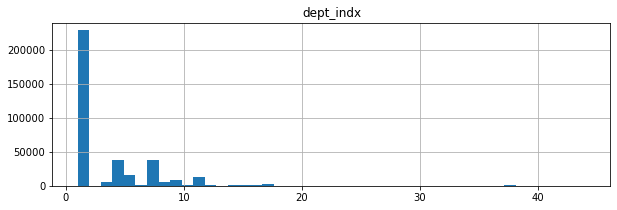

In [471]:
for ind in range(1,8):
    test[test['weekday'] == ind].hist('dept_indx',figsize = (10,3), bins=len(list_dept))


### Покупки по дням недели ###

<AxesSubplot:xlabel='weekday', ylabel='Density'>

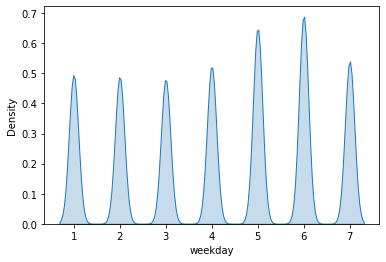

In [459]:
sns.kdeplot(data=test['weekday'],fill=True)

### Количество покупок по дням в первый год работы магазина

array([[<AxesSubplot:title={'center':'day'}>]], dtype=object)

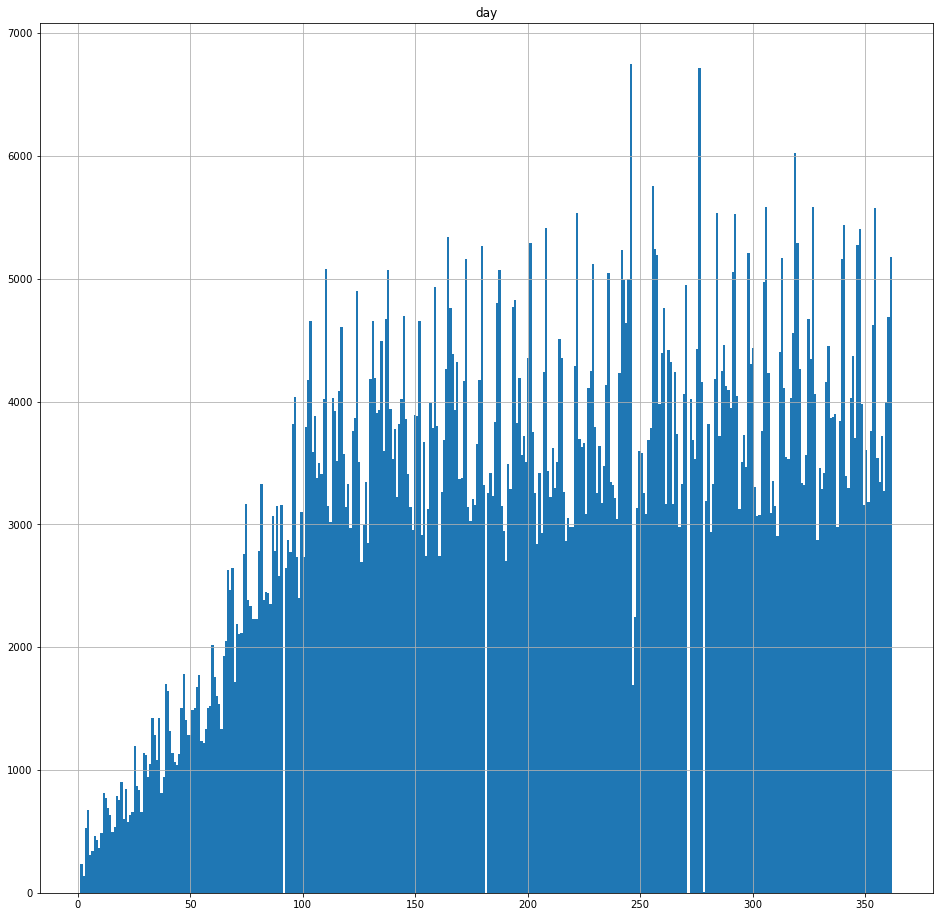

In [473]:
test[test['week_no']<=52].hist('day',figsize=(16,16),bins=365)

### 3. LightFM

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 17%  

У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

### *Отбор признаков* * 

Все данные категориальные, при ohe кодировании для товаров признаков становится невероятно много.      
Какие стратегии отбора признаков в классическом ML Вы знаете? Применимы ли они тут?  

Попробйте какие-нибудь стратегии. Удалось ли улучшить качество?

 \* *задание необязательно*


In [ ]:
data_filtered = prefilter_items(data)

In [474]:
%%time
data = prefilter_items(data)

Wall time: 6.31 s


In [476]:
data.describe().style.set_precision(0)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
count,1079613,1079613,1079613,1079613,1079613,1079613,1079613,1079613,1079613,1079613,1079613,1079613,1079613
mean,1276,34088317958,391,2228258,1,5,3333,-1,1563,57,-0,-0,4
std,722,4742827639,191,3050786,1,4,9210,2,396,27,0,0,3
min,1,26984851516,1,818981,0,2,1,-180,0,1,-56,-3,2
25%,671,30503918029,230,983584,1,3,333,-1,1309,34,0,0,2
50%,1274,32835682876,394,999999,1,3,372,0,1614,57,0,0,3
75%,1907,40186351956,558,1088771,1,5,424,0,1843,80,0,0,4
max,2500,42305362535,711,18119016,40,325,34280,4,2359,102,0,0,50


In [475]:
%%time
model = MainRecommender(data)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 7.14 s
